In [156]:
import json
# import artm
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import f1_score
# from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC
# from collections import Counter
# from itertools import product
# from tqdm import tqdm
# import pickle
# import warnings
# warnings.filterwarnings("ignore", category=DeprecationWarning)


### Load collection

In [ ]:
train_file = 'train'
labels = []
texts = []
with open('train', 'r') as train:
    for i, line in enumerate(train):
        sample = json.loads(line)
        labels.append(sample['label'])
        texts.append(sample['text'].split())

In [119]:
print(f'Number of documents: {len(texts)}, labels: {set(labels)}')

Number of documents: 650000, labels: {1, 2, 3, 4, 5}


In [49]:
texts[0][:10]

['dr',
 'goldberg',
 'offer',
 'everything',
 'look',
 'general',
 'practitioner',
 'nice',
 'easy',
 'talk']

In [ ]:
i = 0
for text in texts:
    if 'go' in text:
        i += 1
        print(text)
    if i > 5:
        break

### Delete uninformative words

In [51]:
token_to_counter = Counter()
for text in texts:
    token_to_counter.update(set(text))

token_to_counter.most_common(30)

[('n', 287931),
 ('go', 278010),
 ('get', 275094),
 ('place', 270373),
 ('good', 249486),
 ('food', 243176),
 ('like', 217516),
 ('would', 209847),
 ('time', 205797),
 ('one', 189008),
 ('service', 187710),
 ('come', 177887),
 ('great', 176751),
 ('back', 166143),
 ('make', 158980),
 ('order', 156464),
 ('really', 147502),
 ('say', 142458),
 ('try', 140430),
 ('take', 135825),
 ('even', 120517),
 ('want', 117885),
 ('give', 117636),
 ('look', 116667),
 ('think', 115042),
 ('could', 114988),
 ('ni', 114922),
 ('also', 111680),
 ('nthe', 108726),
 ('nice', 107045)]

In [61]:
stopwords = set(['n', 'go', 'get', 'even', 'ni', 'also', 'nthe'])

for i, text in enumerate(texts):
    texts[i] = [t for t in text if t not in stopwords]

In [120]:
train_texts, val_texts, train_target, val_target = train_test_split(texts, labels, test_size=0.3,
                                                                    random_state=42, stratify=labels)
print(f'Train len: {len(train_texts)}, val len: {len(val_texts)}')

Train len: 455000, val len: 195000


### Use VowpalWabbit format

In [121]:
train_vw_file = 'train_vw'
val_vw_file = 'val_vw'

In [122]:
with open(train_vw_file, 'w') as train_vw:
    for i, text in enumerate(train_texts):
        train_vw.write(f'doc_{i} ' + ' '.join(text) + '\n')

with open(val_vw_file, 'w') as val_vw:
    for i, text in enumerate(val_texts):
        val_vw.write(f'doc_{i} ' + ' '.join(text) + '\n')

In [123]:
!head -n3 train_vw

doc_0 first sonic burger yesterday expect sonic blast w reese damn though
doc_1 lot inventory damage disorganize place everything thin coat dirt counter
doc_2 place awesome today hubby price kid jump hour military discount thank skyzone support troops blast together age fun perfect birthday party venue see couple without kid athletic date outing dress accordingly break sweat suggestion bench seat entrance jump zone least kid zone newborn plus watch kid nowhere sit stand whole time baby food court area cool selection though bring lot business jump enjoy yummy frozen yogurt price lot addon noverall definitely love place often family fun


### Create model

In [124]:
bv_train = artm.BatchVectorizer(data_path=train_vw_file, data_format='vowpal_wabbit',
                                batch_size=10000, target_folder='batches/train')
bv_val = artm.BatchVectorizer(data_path=val_vw_file, data_format='vowpal_wabbit',
                              batch_size=10000, target_folder='batches/val')

In [ ]:
from functools import partial
get_artm = partial(artm.ARTM, dictionary=bv_train.dictionary, class_ids={'@default_class': 1.0})

In [125]:
model = artm.ARTM(num_topics=10, num_document_passes=3, dictionary=bv_train.dictionary,
                  class_ids={'@default_class': 1.0}, cache_theta=True)
model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=bv_train.dictionary))
model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=10))

In [67]:
for i in range(20):
    model.fit_offline(bv_train, num_collection_passes=1)
    print(f'Iter #{i}, perplexity: {model.score_tracker["perplexity"].last_value:.2f}')

Iter #0, perplexity: 313523.28125
Iter #1, perplexity: 2586.05908203125
Iter #2, perplexity: 2566.085205078125
Iter #3, perplexity: 2519.105224609375
Iter #4, perplexity: 2464.97314453125
Iter #5, perplexity: 2401.595703125
Iter #6, perplexity: 2320.114501953125
Iter #7, perplexity: 2236.48388671875
Iter #8, perplexity: 2164.56103515625
Iter #9, perplexity: 2106.6015625
Iter #10, perplexity: 2060.53662109375
Iter #11, perplexity: 2023.7037353515625
Iter #12, perplexity: 1993.849609375
Iter #13, perplexity: 1969.435302734375
Iter #14, perplexity: 1949.4158935546875
Iter #15, perplexity: 1932.9022216796875


In [127]:
top_tokens = model.score_tracker['top-tokens'].last_tokens

for topic_name in model.topic_names:
    print(top_tokens[topic_name])

['room', 'stay', 'hotel', 'vegas', 'night', 'strip', 'free', 'like', 'clean', 'nice']
['hour', 'happy', 'service', 'look', 'close', 'new', 'amazing', 'year', 'time', 'cut']
['tell', 'call', 'take', 'say', 'time', 'show', 'customer', 'ask', 'work', 'never']
['place', 'drink', 'bar', 'friend', 'pretty', 'beer', 'people', 'see', 'time', 'night']
['chicken', 'burger', 'sauce', 'order', 'eat', 'like', 'fries', 'dish', 'roll', 'sushi']
['pizza', 'order', 'cheese', 'small', 'star', 'two', 'give', 'want', 'eat', 'think']
['food', 'service', 'restaurant', 'menu', 'table', 'time', 'meal', 'taco', 'nothing', 'seat']
['come', 'place', 'order', 'say', 'wait', 'like', 'take', 'minute', 'make', 'time']
['little', 'buffet', 'breakfast', 'coffee', 'dessert', 'like', 'cream', 'ice', 'try', 'worth']
['find', 'location', 'store', 'like', 'price', 'love', 'look', 'shop', 'need', 'buy']


## Classification

In [192]:
class ARTM:
    def __init__(self, dct, n_topics=10, portion_back=None, tau_back=None, tau_sparse=None, tau_decor=None):
        model = artm.ARTM(num_topics=n_topics, num_document_passes=3, dictionary=dct,
                          class_ids={'@default_class': 1.0})
        model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=dct))
        model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=10))
        model.scores.add(artm.SparsityPhiScore(name='sparsity'))
        
        if tau_back is not None:
            n_back = int(n_topics * portion_back)
            model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='smooth', tau=tau_back,
                                                                   dictionary=dct,
                                                                   topic_names=model.topic_names[:n_back]))
        if tau_sparse is not None:
            model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='sparse', tau=tau_sparse,
                                                                   dictionary=dct,
                                                                   topic_names=model.topic_names[n_back:]))
        if tau_decor is not None:
            model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator', tau=tau_decor))
        
        self.model = model
        
    def fit(self, bv, y=None):
        self.model.fit_offline(bv, num_collection_passes=20)
        return self
        
    def transform(self, bv, y=None):
        X = self.model.transform(batch_vectorizer=bv).T.to_numpy()
        return X

In [193]:
from sklearn.pipeline import Pipeline

In [195]:
artm_svc = Pipeline([
    ('artm', ARTM(bv_train.dictionary)),
    ('svc', SVC())])

NameError: name 'SVC' is not defined

In [136]:
def get_model(bv, n_topics, portion_back=None, tau_back=None, tau_sparse=None, tau_decor=None):
    model = artm.ARTM(num_topics=n_topics, num_document_passes=3, dictionary=bv.dictionary,
                      class_ids={'@default_class': 1.0})
    model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=bv.dictionary))
    model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=10))
    model.scores.add(artm.SparsityPhiScore(name='sparsity'))
    
    if portion_back is not None:
        n_back = int(n_topics * portion_back)
        model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='smooth', tau=tau_back,
                                                               dictionary=bv.dictionary,
                                                               topic_names=model.topic_names[:n_back]))
    if tau_sparse is not None:
        model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='sparse', tau=tau_sparse,
                                                               dictionary=bv.dictionary,
                                                               topic_names=model.topic_names[n_back:]))
        model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator', tau=tau_decor))

    model.fit_offline(bv, num_collection_passes=20)
    parameters = {'n_topics': n_topics, 'portion_back': portion_back, 'tau_back': tau_back,
                  'tau_sparse': tau_sparse, 'tau_decor': tau_decor}
    return model, parameters

In [143]:
def classify(artm_model, bv_train, bv_val, cls, train_target, val_target):
    train_X = artm_model.transform(batch_vectorizer=bv_train).T.to_numpy()
    val_X = artm_model.transform(batch_vectorizer=bv_val).T.to_numpy()
    cls.fit(X=train_X, y=train_target)
    return f1_score(y_true=val_target, y_pred=cls.predict(X=val_X), average='micro')

In [138]:
N_topics = [10, 20]

taus_back = [1e2, 1e3]
portions_back = [0.1, 0.2, 0.3, 0.4]
taus_sparse = [1e2, 1e3]
taus_decor = [1e5, 1e6]

classifiers = ['LogReg', 'SVM']
name_to_cls = {'LogReg': LogisticRegression(), 'SVM': LinearSVC()}

### No regularization

In [144]:
results = []
grid = product(N_topics, classifiers)
for n_topics, cls_name in tqdm(grid):
    model, parameters = get_model(bv_train, n_topics)
    parameters['cls'] = cls_name
    f1 = classify(model, bv_train, bv_val, name_to_cls[cls_name], train_target, val_target)
    top_tokens = model.score_tracker['top-tokens'].last_tokens
    result = {'parameters': parameters,
              'perplexity': model.score_tracker["perplexity"].value,
              'sparsity': model.score_tracker["sparsity"].value,
              'top-tokens': [top_tokens[topic_name] for topic_name in model.topic_names],
              'f1': f1}
    results.append(result)

4it [16:43, 250.83s/it]


In [157]:
results_dir = 'results'
with open(f'{results_dir}/result_noreg.pickle', 'wb') as handle:
    pickle.dump(results, handle)

In [158]:
results[0]['parameters']

{'n_topics': 10,
 'portion_back': None,
 'tau_back': None,
 'tau_sparse': None,
 'tau_decor': None,
 'cls': 'LogReg'}

Text(0, 0.5, 'Perplexity')

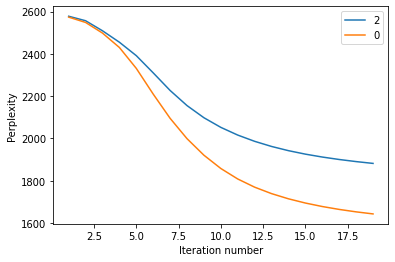

In [166]:
plt.plot(range(1, 20), results[0]['perplexity'][1:], label="10 topics")
plt.plot(range(1, 20), results[2]['perplexity'][1:], label="20 topics")
plt.xlabel("Iteration number")
plt.ylabel("Perplexity")
plt.legend()
plt.show()

Text(0, 0.5, 'Sparsity')

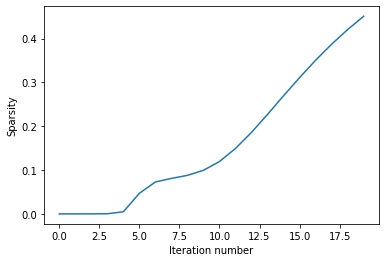

In [163]:
plt.plot(results[0]['sparsity'], label="10 topics")
plt.plot(results[2]['sparsity'], label="20 topics")
plt.xlabel("Iteration number")
plt.ylabel("Sparsity")
plt.legend()
plt.show()

In [173]:
for res in results:
    print(f"F1 score for {res['parameters']['cls']}, {res['parameters']['n_topics']} topics: {res['f1']:.4f}")

F1 score for LogReg, 10 topics: 0.1992
F1 score for SVM, 10 topics: 0.1993
F1 score for LogReg, 20 topics: 0.1988
F1 score for SVM, 20 topics: 0.1988


## Adding background topics

In [190]:
results = []
grid = product(N_topics, classifiers, [1e3], portions_back)
for n_topics, cls_name, tau_back, portion_back in tqdm(grid):
    model, parameters = get_model(bv_train, n_topics, portion_back=portion_back, tau_back=tau_back)
    parameters['cls'] = cls_name
    f1 = classify(model, bv_train, bv_val, name_to_cls[cls_name], train_target, val_target)
    top_tokens = model.score_tracker['top-tokens'].last_tokens
    result = {'parameters': parameters,
              'perplexity': model.score_tracker["perplexity"].value,
              'sparsity': model.score_tracker["sparsity"].value,
              'top-tokens': [top_tokens[topic_name] for topic_name in model.topic_names],
              'f1': f1}
    results.append(result)

12it [56:43, 283.63s/it]


KeyboardInterrupt: 

In [191]:
with open(f'{results_dir}/result_back.pickle', 'wb') as handle:
    pickle.dump(results, handle)

In [ ]:
for cls_name in classifiers:
    for n_topics in N_topics:
        scores = [res['f1'] for res in results if res['parameters']['cls'] == cls_name\
                  and res['parameters']['n_topics'] == n_topics]
        plt.plot(portions_back, scores, label=f"{cls_name}, {n_topics} topics")
        plt.xlabel("Background themes portion")
        plt.ylabel("F1")
plt.legend()

## Decorrelation

In [ ]:
n_topics_best = 10
cls_name_best = 'LogReg'
tau_back_best = 1e3

results = []
grid = product(portions_back, taus_decor)
for portion_back, tau_decor in tqdm(grid):
    model, parameters = get_model(bv_train, n_topics_best, portion_back=portion_back,
                                  tau_back=tau_back_best, tau_decor=tau_decor)
    parameters['cls'] = cls_name_best
    f1 = classify(model, bv_train, bv_val, name_to_cls[cls_name_best], train_target, val_target)
    top_tokens = model.score_tracker['top-tokens'].last_tokens
    result = {'parameters': parameters,
              'perplexity': model.score_tracker["perplexity"].value,
              'sparsity': model.score_tracker["sparsity"].value,
              'top-tokens': [top_tokens[topic_name] for topic_name in model.topic_names],
              'f1': f1}
    results.append(result)

In [ ]:
with open(f'{results_dir}/result_decor.pickle', 'wb') as handle:
    pickle.dump(results, handle)

## Sparsification

In [ ]:
tau_decor_best = 1e5

results = []
grid = product(portions_back, taus_sparse)
for portion_back, tau_sparse in tqdm(grid):
    model, parameters = get_model(bv_train, n_topics_best, portion_back=portion_back,
                                  tau_back=tau_back_best, tau_decor=tau_decor_best, tau_sparse=tau_sparse)
    parameters['cls'] = cls_name_best
    f1 = classify(model, bv_train, bv_val, name_to_cls[cls_name_best], train_target, val_target)
    top_tokens = model.score_tracker['top-tokens'].last_tokens
    result = {'parameters': parameters,
              'perplexity': model.score_tracker["perplexity"].value,
              'sparsity': model.score_tracker["sparsity"].value,
              'top-tokens': [top_tokens[topic_name] for topic_name in model.topic_names],
              'f1': f1}
    results.append(result)

In [ ]:
with open(f'{results_dir}/result_decor.pickle', 'wb') as handle:
    pickle.dump(results, handle)

In [181]:
results
for res in results:
    print(res['parameters']['tau_back'], res['f1'])

10 0.19921025641025641
10 0.19923076923076924
10 0.19924102564102564
10 0.19923589743589742
100.0 0.1992205128205128
100.0 0.19924615384615385
100.0 0.1992205128205128


In [188]:
results = []
grid = product([10], ['LogReg'], [100000], [0.2])
for n_topics, cls_name, tau_back, portion_back in tqdm(grid):
    model, parameters = get_model(bv_train, n_topics, portion_back=portion_back, tau_back=tau_back)
    parameters['cls'] = cls_name
    f1 = classify(model, bv_train, bv_val, name_to_cls[cls_name], train_target, val_target)
    top_tokens = model.score_tracker['top-tokens'].last_tokens
    result = {'parameters': parameters,
              'perplexity': model.score_tracker["perplexity"].value,
              'sparsity': model.score_tracker["sparsity"].value,
              'top-tokens': [top_tokens[topic_name] for topic_name in model.topic_names],
              'f1': f1}
    results.append(result)

1it [03:59, 239.03s/it]


In [185]:
results[0]['f1']

0.19934871794871795

In [187]:
results[0]['f1']

0.1994974358974359

In [189]:
results[0]['f1']

0.1994974358974359

In [97]:
grid = product(N_topics, taus_portions_back, taus_sparse_decor)
results_dir = 'results'

it = 0
for n_topics, tau_portion_back, tau_sparse_decor in tqdm(grid):
    if it > 0:
        break
    
    tau_back, portion_back = tau_portion_back
    tau_sparse, tau_decor = tau_sparse_decor
    if tau_decor == 1e5:
        model = get_model(bv, n_topics, portion_back, tau_back, tau_sparse, tau_decor)

        parameters = {'n_topics': n_topics, 'portion_back': portion_back, 'tau_back': tau_back,
                      'tau_sparse': tau_sparse, 'tau_decor': tau_decor}
        result = {'parameters': parameters, 'perplexity': [], 'sparsity': []}
        for i in range(20):
            model.fit_offline(bv, num_collection_passes=1)
            perplexity = model.score_tracker["perplexity"].last_value
            sparsity = model.score_tracker["sparsity"].last_value
            result['perplexity'].append(perplexity)
            result['sparsity'].append(sparsity)

        top_tokens = model.score_tracker['top-tokens'].last_tokens
        result['top-tokens'] = [top_tokens[topic_name] for topic_name in model.topic_names]
        result['theta'] = model.get_theta()

        with open(f'{results_dir}/result_{it}.pickle', 'wb') as handle:
            pickle.dump(result, handle)

        it += 1

2it [05:44, 172.43s/it]


In [98]:
with open('results/result_19.pickle', 'rb') as handle:
    result = pickle.load(handle)

In [99]:
print("DESCRIPTION:", result['parameters'], '\n')
print("PERPLEXITY:", result['perplexity'], '\n')
print("SPARSITY:", result['sparsity'], '\n')
print("TOP TOKENS:", result['top-tokens'])

DESCRIPTION: {'n_topics': 10, 'portion_back': 0.1, 'tau_back': 10, 'tau_sparse': 10, 'tau_decor': 100000.0} 

PERPLEXITY: [313523.28125, 2586.058837890625, 2566.08154296875, 2519.09130859375, 2464.9404296875, 2401.533447265625, 2320.0224609375, 2236.3779296875, 2164.45263671875, 2106.490966796875, 2060.423095703125, 2023.589599609375, 1993.7294921875, 1969.31689453125, 1949.295166015625, 1932.7796630859375, 1919.019287109375, 1907.3822021484375, 1897.428466796875, 1888.8182373046875] 

SPARSITY: [1.5655576817152905e-06, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 

TOP TOKENS: [['room', 'stay', 'hotel', 'vegas', 'strip', 'night', 'free', 'like', 'clean', 'nice'], ['hour', 'happy', 'service', 'look', 'close', 'new', 'amazing', 'year', 'time', 'hair'], ['tell', 'call', 'take', 'time', 'say', 'show', 'customer', 'ask', 'work', 'car'], ['place', 'drink', 'bar', 'pretty', 'friend', 'beer', 'people', 'see', 'nice', 'night'], ['chicken', 'bur

In [100]:
result['theta']

,170000,170001,170002,170003,170004,170005,170006,170007,170008,170009,...,309990,309991,309992,309993,309994,309995,309996,309997,309998,309999
topic_0,0.283193,0.452112,0.535925,0.527817,0.323818,0.531445,0.286066,0.568600,0.643041,0.496274,...,0.016361,0.074090,0.039254,0.049669,0.075123,0.050898,0.081712,0.055124,0.003368,0.021841
topic_1,0.036622,0.024368,0.040415,0.024586,0.124620,0.010490,0.042648,0.015200,0.109974,0.017760,...,0.016777,0.054202,0.069354,0.161219,0.023809,0.089995,0.122173,0.056652,0.059645,0.493905
topic_2,0.451766,0.161228,0.097932,0.259569,0.176654,0.257451,0.221406,0.067270,0.079154,0.156938,...,0.107481,0.088496,0.011835,0.120469,0.073937,0.030360,0.023972,0.007985,0.030518,0.000981
topic_3,0.020884,0.129450,0.030177,0.024625,0.035784,0.026901,0.110320,0.107800,0.023190,0.050897,...,0.008145,0.207455,0.485271,0.234376,0.174788,0.071596,0.172209,0.123435,0.046908,0.029192
topic_4,0.002980,0.020607,0.002391,0.001061,0.007266,0.008965,0.018596,0.006807,0.002893,0.008758,...,0.029963,0.030909,0.025642,0.003373,0.038294,0.108599,0.023267,0.311536,0.094413,0.001472
topic_5,0.032310,0.035904,0.080640,0.031049,0.075946,0.041965,0.086160,0.048664,0.019274,0.066993,...,0.059488,0.144536,0.064304,0.096982,0.141458,0.278575,0.122423,0.224799,0.205001,0.002025
topic_6,0.026154,0.051616,0.024404,0.018118,0.020623,0.011219,0.036221,0.015619,0.014555,0.068468,...,0.261162,0.122658,0.058844,0.076232,0.177268,0.128072,0.194790,0.046678,0.104923,0.391717
topic_7,0.117682,0.010071,0.101362,0.039891,0.152872,0.056085,0.144950,0.060892,0.102403,0.054753,...,0.491154,0.083728,0.034596,0.151471,0.146786,0.059765,0.116745,0.015168,0.137073,0.008049
topic_8,0.006392,0.058913,0.010563,0.006659,0.036755,0.004844,0.032254,0.027665,0.002442,0.028911,...,0.004025,0.064684,0.044830,0.010017,0.045030,0.085397,0.121991,0.102583,0.173336,0.016278
topic_9,0.022017,0.055731,0.076190,0.066625,0.045662,0.050635,0.021378,0.081481,0.003074,0.050248,...,0.005445,0.129244,0.166069,0.096192,0.103506,0.096742,0.020718,0.056039,0.144814,0.034540
